# Seq2Seq Polski --> Angielski
https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
torch.cuda.device_count()

0

### Konwersja słów na index

In [3]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

### Normalizacja tekstu

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

### Wczytywanie danych (zmodyfikowane ze względu na ścieżkę w kaggle)

In [7]:
def readLangs(reverse=False):
    print("Reading lines...")
    lang1="en"
    lang2="pol"
    # Read the file and split into lines
    lines = open('pol.txt', encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[:-1]] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

#### Ograniczenie do zdań max 10 słów, formy I am / You are / He is etc. bez interpunkcji

In [8]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [9]:
def prepareData(reverse=False):
    input_lang, output_lang, pairs = readLangs(reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData(True)
print(random.choice(pairs))

Reading lines...
Read 49943 sentence pairs
Trimmed to 3613 sentence pairs
Counting words...
Counted words:
pol 3070
en 1969
['jestem tylko mechanikiem', 'i m only the mechanic']


### Definicja modelu

In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [11]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [12]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [13]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData(True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [14]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [15]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [16]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [18]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

### Ewaluacja

In [19]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [20]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('Input sentence: ', pair[0])
        print('Target (true) translation:' , pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('Output sentence: ', output_sentence)
        print('')

# Wykorzystanie zdefiniowanych wyżej funkcji

### Trenowanie modelu

Reading lines...
Read 49943 sentence pairs
Trimmed to 3613 sentence pairs
Counting words...
Counted words:
pol 3070
en 1969
0m 47s (- 11m 58s) (5 6%) 2.1245
1m 33s (- 10m 57s) (10 12%) 1.2482
2m 13s (- 9m 36s) (15 18%) 0.8442
2m 51s (- 8m 35s) (20 25%) 0.5612
3m 32s (- 7m 46s) (25 31%) 0.3599
4m 10s (- 6m 56s) (30 37%) 0.2216
4m 51s (- 6m 15s) (35 43%) 0.1367
5m 30s (- 5m 30s) (40 50%) 0.0894
6m 9s (- 4m 47s) (45 56%) 0.0647
6m 48s (- 4m 5s) (50 62%) 0.0489
7m 27s (- 3m 23s) (55 68%) 0.0402
8m 8s (- 2m 42s) (60 75%) 0.0345
8m 48s (- 2m 1s) (65 81%) 0.0315
9m 25s (- 1m 20s) (70 87%) 0.0278
10m 3s (- 0m 40s) (75 93%) 0.0271
10m 42s (- 0m 0s) (80 100%) 0.0253


<Figure size 640x480 with 0 Axes>

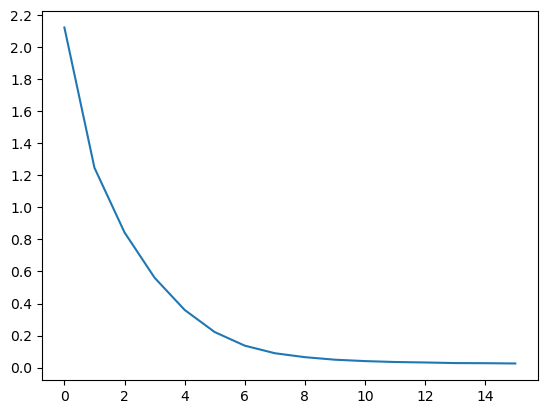

In [21]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

In [22]:
evaluateRandomly(encoder, decoder)

Input sentence:  ciesze sie ze by em w stanie pomoc
Target (true) translation: i m glad i was able to help
Output sentence:  i m glad i was able to help <EOS>

Input sentence:  to moja matka chrzestna
Target (true) translation: she s my godmother
Output sentence:  she s my godmother by three <EOS>

Input sentence:  nie gram w zadna gre
Target (true) translation: i m not playing a game
Output sentence:  i m not playing a game <EOS>

Input sentence:  jestem wyzszy
Target (true) translation: i am taller
Output sentence:  i am taller <EOS>

Input sentence:  jestes zdesperowany
Target (true) translation: you re desperate
Output sentence:  you re desperate <EOS>

Input sentence:  zostane zwolniony
Target (true) translation: i m going to get fired
Output sentence:  i m going to be arrested i think <EOS>

Input sentence:  mamy dzisiaj rybe jako g owne danie
Target (true) translation: we are having fish for our main course
Output sentence:  we are having fish for our main course <EOS>

Input se

In [23]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    input_sentence = normalizeString(input_sentence)
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

def translate(input_sentence, tokenized=False):
    input_sentence = normalizeString(input_sentence)
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    if tokenized:
        if "<EOS>" in output_words:
            output_words.remove("<EOS>")
        return output_words
    return ' '.join(output_words)

In [24]:
translate("Jesteśmy głodni", tokenized=True)

['we', 'are', 'hungry']

input = jestes zbyt naiwny
output = you re too naive <EOS>


C:\Users\Michał\AppData\Local\Temp\ipykernel_10608\712218569.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
C:\Users\Michał\AppData\Local\Temp\ipykernel_10608\712218569.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


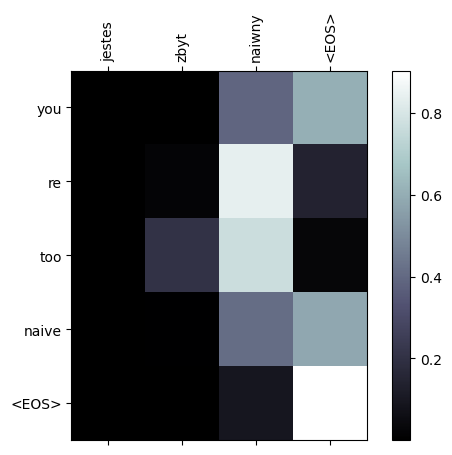

In [25]:
evaluateAndShowAttention('Jesteś zbyt naiwny')

input = naprawde mi przykro
output = i m really sorry <EOS>


C:\Users\Michał\AppData\Local\Temp\ipykernel_10608\712218569.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
C:\Users\Michał\AppData\Local\Temp\ipykernel_10608\712218569.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


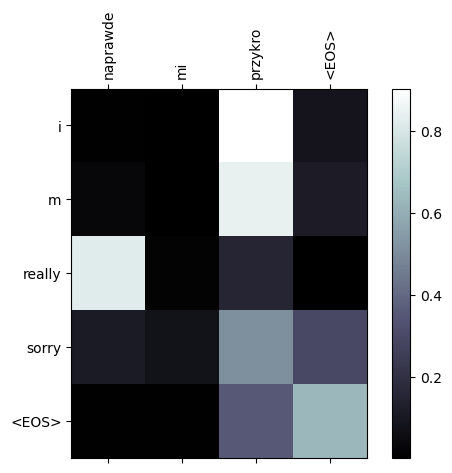

In [26]:
evaluateAndShowAttention('Naprawdę mi przykro')

input = jestes moim ojcem
output = you are my father <EOS>


C:\Users\Michał\AppData\Local\Temp\ipykernel_10608\712218569.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
C:\Users\Michał\AppData\Local\Temp\ipykernel_10608\712218569.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


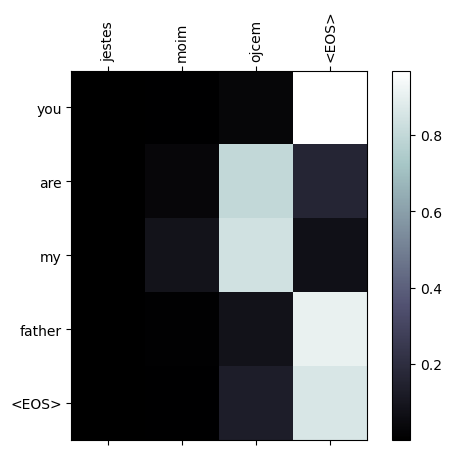

In [27]:
evaluateAndShowAttention('Jesteś moim ojcem')

input = on tez jest nauczycielem
output = he is a teacher too <EOS>


C:\Users\Michał\AppData\Local\Temp\ipykernel_10608\712218569.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
C:\Users\Michał\AppData\Local\Temp\ipykernel_10608\712218569.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


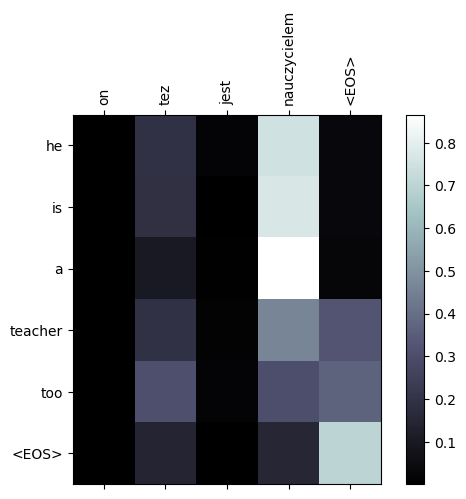

In [29]:
evaluateAndShowAttention('On też jest nauczycielem')

In [30]:
torch.save(encoder.state_dict(), "encoder.pt")
torch.save(decoder.state_dict(), "decoder.pt")

# BLEU score

Jako że korzystaliśmy z okrojonej wersji zbioru danych, słownik nie zawiera wszystkich słów pojawiających się w przykładach więc do ewaluacji wykorzystujemy część przykładów z treningu

In [32]:
import pandas as pd


def filter_rows(row):
    return len(row["English"].split(' '))<MAX_LENGTH and \
                        len(row["Polish"].split(' '))<MAX_LENGTH and \
                        row["English"].startswith(eng_prefixes)
data_file = pd.read_csv("pol.txt", sep='\t', names=["English","Polish","attribution"])
data_file["English"] = data_file["English"].apply(normalizeString)
data_file["Polish"] = data_file["Polish"].apply(normalizeString)

filter_list = data_file.apply(filter_rows, axis=1)

test_section = data_file[filter_list]
test_section = test_section.sample(frac=1).head(500)
test_section.head()

English                        Polish  \
13492              i m the last in line      jestem ostatni w kolejce   
14379              you are not a coward           nie jestes tchorzem   
31538    we re anxious about her health    martwimy sie o jej zdrowie   
33382  he s not at all afraid of snakes  on zupe nie nie boi sie wezy   
13031              he is a fast speaker                on szybko mowi   

                                             attribution  
13492  CC-BY 2.0 (France) Attribution: tatoeba.org #5...  
14379  CC-BY 2.0 (France) Attribution: tatoeba.org #1...  
31538  CC-BY 2.0 (France) Attribution: tatoeba.org #7...  
33382  CC-BY 2.0 (France) Attribution: tatoeba.org #2...  
13031  CC-BY 2.0 (France) Attribution: tatoeba.org #3...

In [33]:
test_section["English_tokenized"] = test_section["English"].apply(lambda x: x.split())

In [34]:
test_section.head()["English_tokenized"]

13492                  [i, m, the, last, in, line]
14379                   [you, are, not, a, coward]
31538        [we, re, anxious, about, her, health]
33382    [he, s, not, at, all, afraid, of, snakes]
13031                   [he, is, a, fast, speaker]
Name: English_tokenized, dtype: object

In [35]:
test_section["English_translated"] = test_section["Polish"].apply(lambda x: translate(x, tokenized=True))

In [36]:
test_section.head()

English                        Polish  \
13492              i m the last in line      jestem ostatni w kolejce   
14379              you are not a coward           nie jestes tchorzem   
31538    we re anxious about her health    martwimy sie o jej zdrowie   
33382  he s not at all afraid of snakes  on zupe nie nie boi sie wezy   
13031              he is a fast speaker                on szybko mowi   

                                             attribution  \
13492  CC-BY 2.0 (France) Attribution: tatoeba.org #5...   
14379  CC-BY 2.0 (France) Attribution: tatoeba.org #1...   
31538  CC-BY 2.0 (France) Attribution: tatoeba.org #7...   
33382  CC-BY 2.0 (France) Attribution: tatoeba.org #2...   
13031  CC-BY 2.0 (France) Attribution: tatoeba.org #3...   

                               English_tokenized  \
13492                [i, m, the, last, in, line]   
14379                 [you, are, not, a, coward]   
31538      [we, re, anxious, about, her, health]   
33382  [he, s, not, at, all, afraid, of, snakes]   
13031                 [he, is, a, fast, speaker]   

                                      English_translated  
13492                        [i, m, the, last, in, line]  
14379                         [you, are, not, a, coward]  
31538             [we, are, worried, about, her, health]  
33382  [he, s, not, afraid, of, snakes, at, all, afraid]  
13031                  [he, is, a, fast, speaker, young]

In [37]:
candidate_corpus = test_section["English_translated"].values
references_corpus = test_section["English_tokenized"].values.tolist()
x = candidate_corpus.tolist()
y = [[el] for el in references_corpus]

In [38]:
y[:5]

[[['i', 'm', 'the', 'last', 'in', 'line']],
 [['you', 'are', 'not', 'a', 'coward']],
 [['we', 're', 'anxious', 'about', 'her', 'health']],
 [['he', 's', 'not', 'at', 'all', 'afraid', 'of', 'snakes']],
 [['he', 'is', 'a', 'fast', 'speaker']]]

In [39]:
from torchtext.data.metrics import bleu_score

bleu_score(x, y)

C:\Users\Michał\AppData\Roaming\Python\Python310\site-packages\torchtext\data\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


0.8122377991676331